# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Which of the 3 target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest prediction accuracy on the test set? Why is this? __[5 marks]__

# Task 1: Read the _hourly_ data and split into training and test data.

##Start of Answer 1##

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik


import os
from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler,MaxAbsScaler
from sklearn.linear_model import Ridge
from statsmodels.graphics.gofplots import qqplot
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report




# Load Dataset

In [2]:
df = pd.read_csv("Bike-Sharing-Dataset/hour.csv")
print("Hourly", df.shape)
df.head(5)

Hourly (17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


 ## Check  if  there are any NaNs in dataset      

In [3]:
print("Missing Data : " + str(df.isnull().values.any()))

Missing Data : False


## Check dataframe data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [5]:
df = df.rename(columns={ 'dteday':'date',
                        'weathersit':'weather',
                       'yr':'year',
                       'mnth':'month',
                       'hr':'hour',
                       'hum':'humidity',
                       'cnt':'count'})
df.columns.values

array(['instant', 'date', 'season', 'year', 'month', 'hour', 'holiday',
       'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'count'], dtype=object)

- Data types are mostly numerical aside from the date however we wont be using the date so there is no need of changing it. Since there are no nulls and data types are ok there isnt anything to cleanup

 # Split into Test and Training

## Set Feautures and Targets

In [6]:
features, targets = df[['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather',
 'temp', 'atemp', 'humidity', 'windspeed']], df[['casual', 'registered', 'count']]
print("Features : ", features.columns.values)
print("Targets : ", targets.columns.values)

Features :  ['season' 'year' 'month' 'hour' 'holiday' 'weekday' 'workingday' 'weather'
 'temp' 'atemp' 'humidity' 'windspeed']
Targets :  ['casual' 'registered' 'count']


## Split Data Into Train and Test 6:4

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, train_size=0.6, random_state=666)

##End of Answer 1##

# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model

## Checking for data skewness

[Text(0.5, 1.0, 'Theoritical quantiles')]

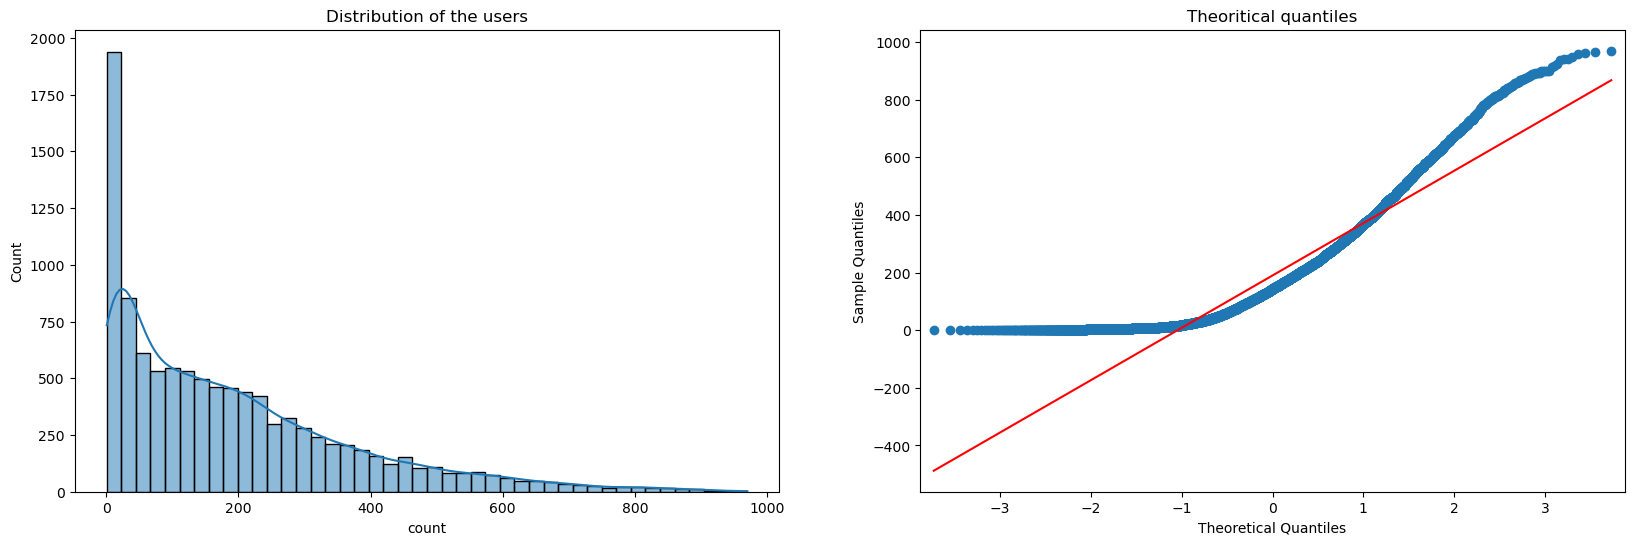

In [8]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
sns.histplot(y_train['count'], kde=True, ax=ax1)
ax1.set(title='Distribution of the users')
qqplot(y_train['count'], ax=ax2, line='s')
ax2.set(title='Theoritical quantiles')

-  Data seems to have a positive skew

## Transforming count using log transformation

##Start of Answer 2##

In [9]:
y_train['count'] = np.log(y_train['count'])
y_test['count'] = np.log(y_test['count'])

[Text(0.5, 1.0, 'Theoritical quantiles')]

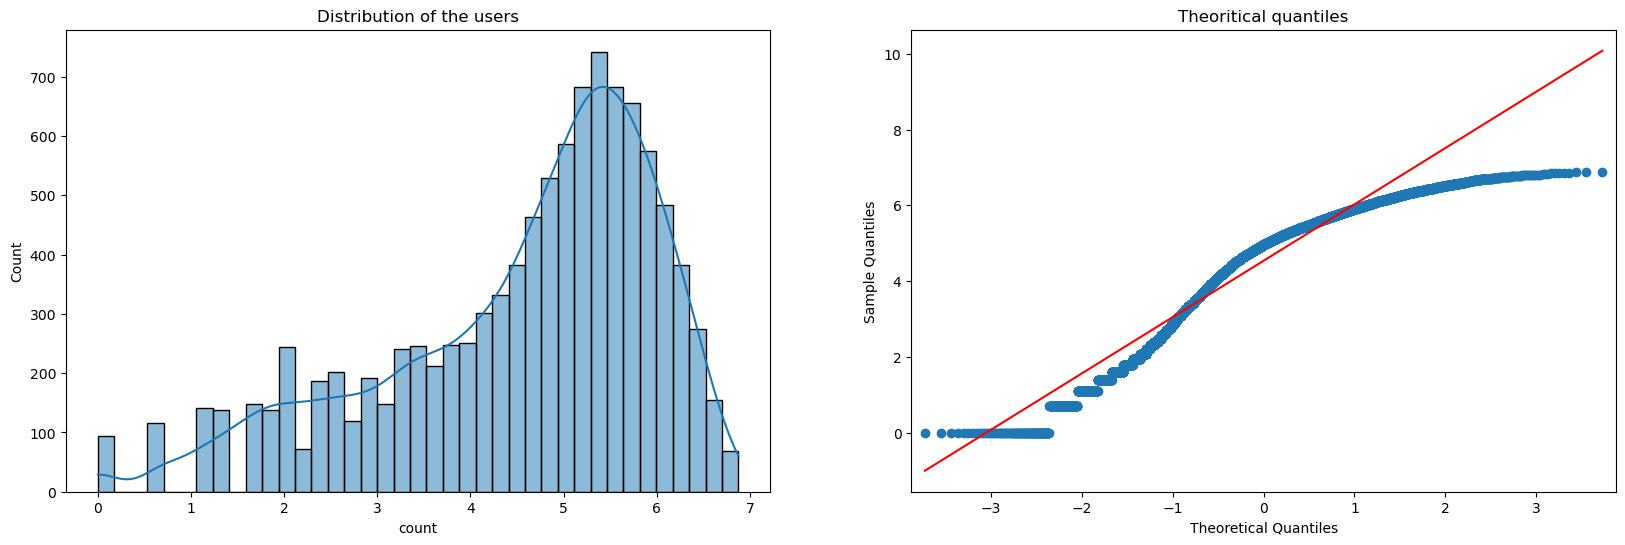

In [10]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,6))
sns.histplot(y_train['count'], kde=True, ax=ax1)
ax1.set(title='Distribution of the users')
qqplot(y_train['count'], ax=ax2, line='s')
ax2.set(title='Theoritical quantiles')

- Data now seems to be more simmetrical ,but still slight skewed (negatively) , this is ok for now as achieving a fyly symetrical dataset would be time consuming and hard

- Note: Log transformation wasnt done for registered and casual as they contain non zero values, this causes NaN value error when fitting the model. A solution for this would be to use a different transformation such as log(x+1) but since count seems to be the best predictor (next best predictor further below) there is no need to do this. log(1+x) was used as transformation to eperiment and gave worse results so were gonna stay with log(x)

## Convert training data into dataframe (joining of features and targets)

In [11]:
df_train = pd.DataFrame()
df_train=X_train.copy()
df_train = df_train.join(y_train.copy())

print("Size Before Split:", df.shape)
print("Size After Split:", df_train.shape)

df_train.head(5)

Size Before Split: (17379, 17)
Size After Split: (10427, 15)


,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
14834,3,1,9,7,0,6,0,1,0.54,0.5152,0.52,0.2836,10,63,4.290459
8912,1,1,1,5,0,4,1,3,0.34,0.3485,0.93,0.0896,0,16,2.772589
7644,4,0,11,3,0,0,0,2,0.40,0.4091,0.66,0.2836,6,31,3.610918
3971,2,0,6,9,0,0,0,2,0.68,0.6364,0.74,0.1045,58,111,5.129899
16570,4,1,11,4,0,3,1,2,0.26,0.2576,0.70,0.1940,0,4,1.386294


## Convert testing data into dataframe (joining of features and targets)

In [12]:
df_test = pd.DataFrame()
df_test = X_test.copy()
df_test = df_test.join(y_test.copy())

print("Size Before Split:", df.shape)
print("Size After Split:", df_test.shape)

df_test.head(5)

Size Before Split: (17379, 17)
Size After Split: (6952, 15)


,season,year,month,hour,holiday,weekday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
3209,2,0,5,15,0,3,1,1,0.60,0.5758,0.78,0.2537,34,133,5.117994
341,1,0,1,17,0,6,0,2,0.32,0.3030,0.36,0.2836,29,54,4.418841
1575,1,0,3,2,0,5,1,3,0.34,0.3485,1.00,0.1045,2,3,1.609438
12273,2,1,5,14,0,4,1,1,0.76,0.6667,0.31,0.1940,61,193,5.537334
10582,2,1,3,1,0,4,1,1,0.52,0.5000,0.83,0.0896,14,16,3.401197


## Plot graphs to visually analyse the data for any relations or possible predictors

<AxesSubplot:xlabel='weather', ylabel='count'>

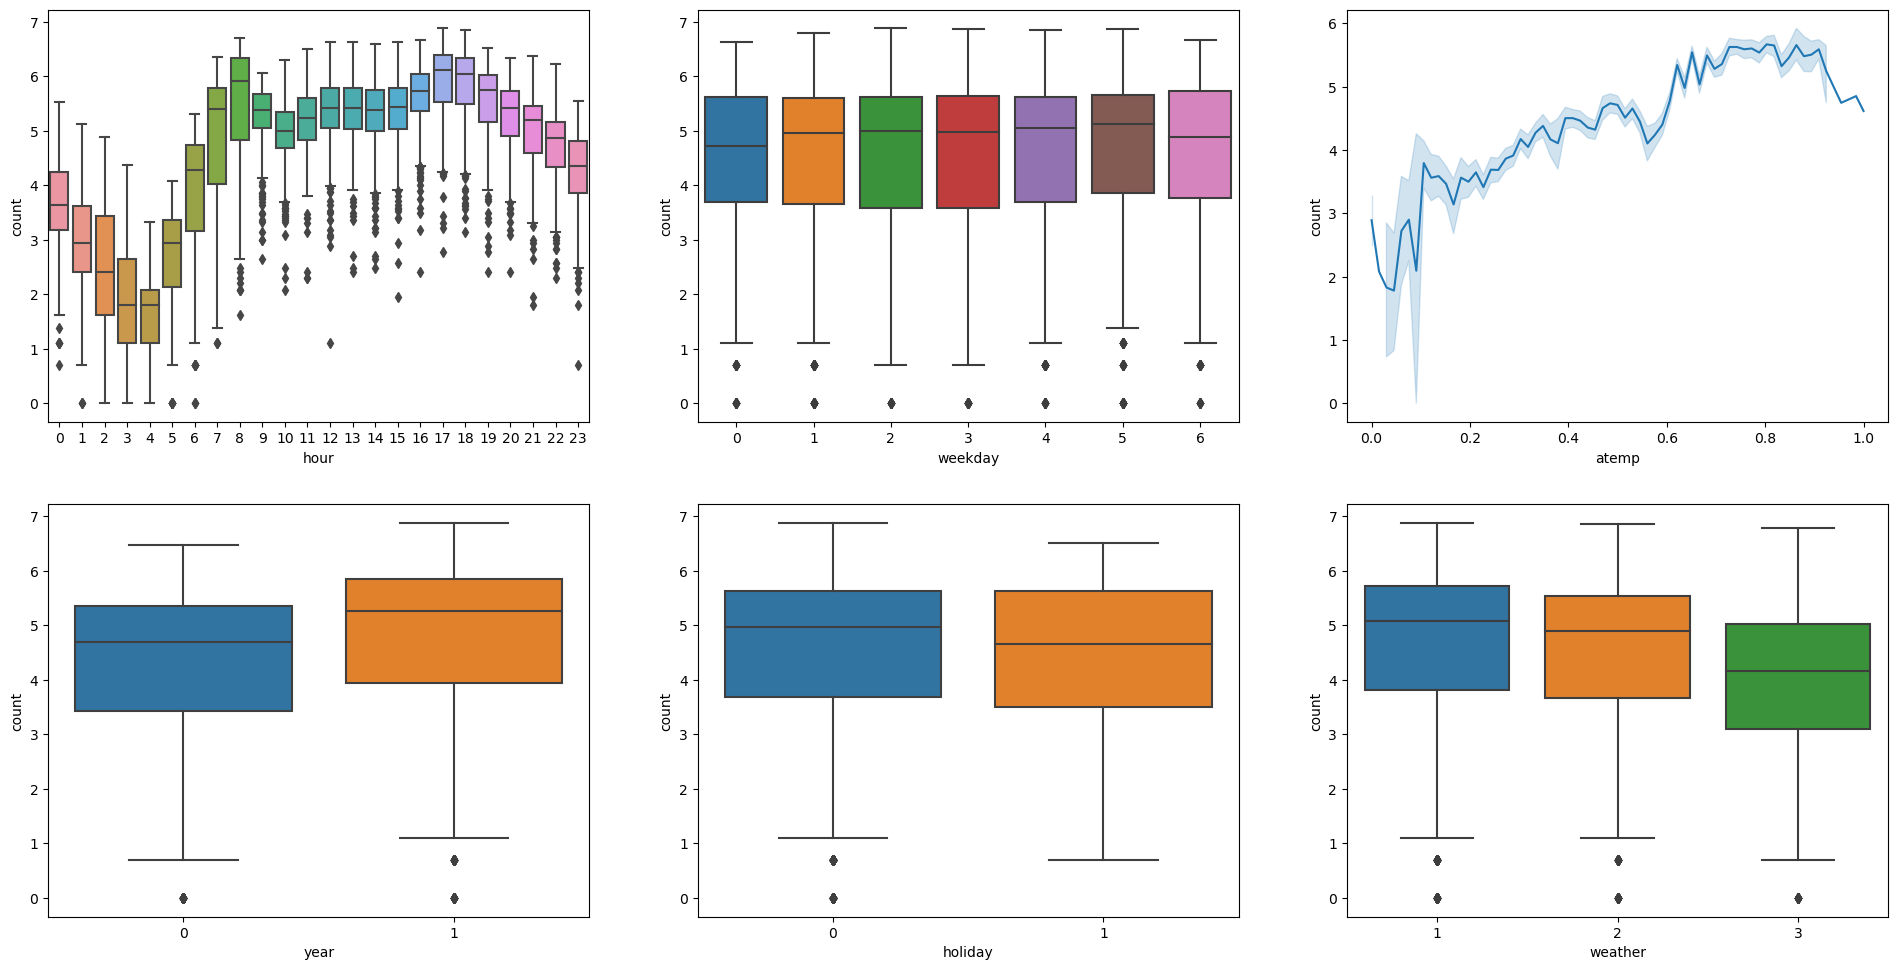

In [13]:
fig ,axes = plt.subplots(2, 3)

# set the spacing between subplots
plt.subplots_adjust(right=3, top=2)

sns.boxplot(data=df_train, x="hour", y="count", ax=axes[0,0])

sns.boxplot(data=df_train, x="weekday", y="count", ax=axes[0,1])

sns.lineplot(data=df_train, x="atemp", y="count", ax=axes[0,2])

sns.boxplot(data=df_train, x="year", y="count", ax=axes[1,0])

sns.boxplot(data=df_train, x="holiday", y="count", ax=axes[1,1])

sns.boxplot(data=df_train, x="weather", y="count", ax=axes[1,2])

-  From the boxplots we can see that the mean bikes rented per day is roughly the same during the week however it slightly decreases on weekends (0,6). 
- The night hours from 10pm-6am tend to have the lowest mean for bikes rented by the hour, the hihghest means are seen around the start and finish of busines hours ie ~8am and ~5pm, the mean then decreases for the duration of business dat ~10am to ~3pm however it is still higher then the night hours. 
- From the lineplot we can see that the average number of bikes rented increases with the temperature to a point and after a certain point it decreases significantly.
- We can also see that the median number of bikes renters was sloghtly higher in more recent year.
- From the holiday boxplot we can also see the the mean is slightly lower during holidays
- The weathersit or weathersitatuin also has a clear decrease of the average count as we move from 1 - 3 , this shows that more people rent bikes when the weather situatuion is clearer with fewerr clouds (1) when compared to misty conditions (2) and raining, snowing or thunderstorm conditions (3)

## Check for any obvious Corelations among features 

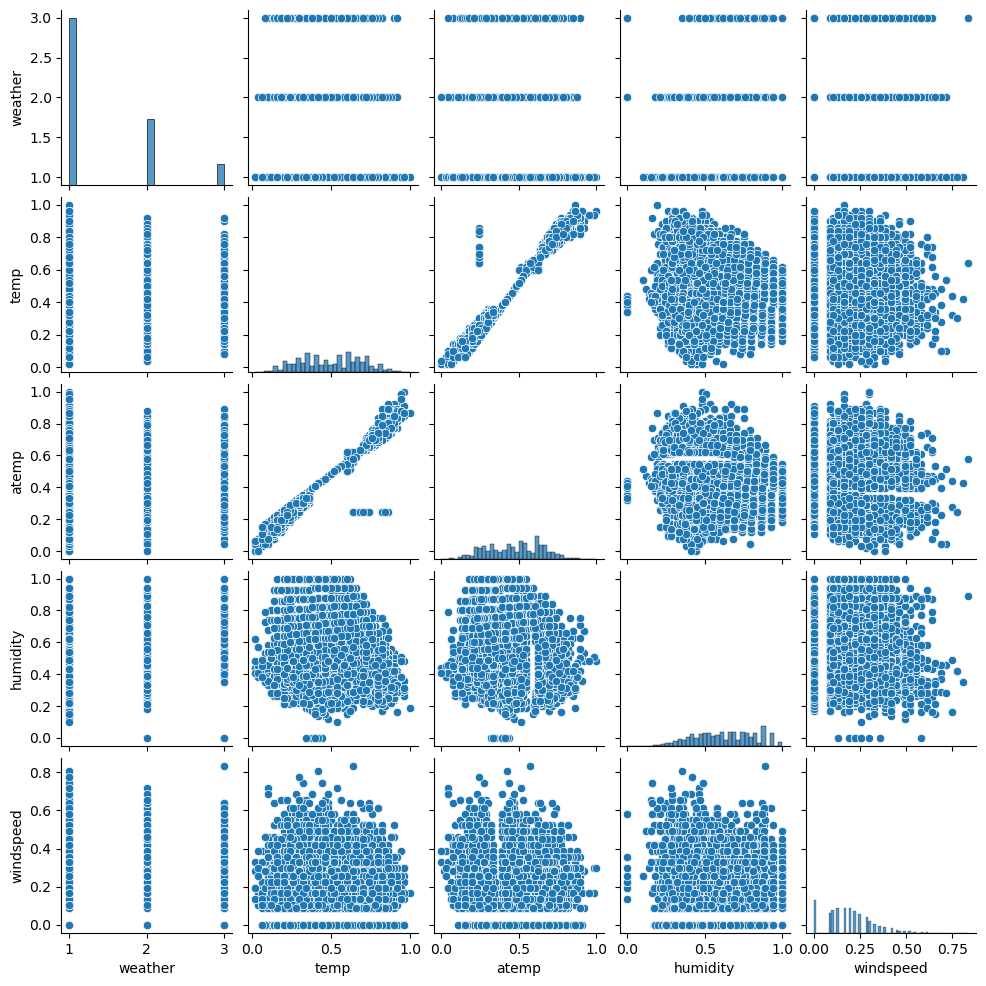

In [14]:
 sns.pairplot(df_train, vars=['weather', 'temp', 'atemp', 'humidity', 'windspeed'], height=2)

- From the pairplot we can see that there is a clear relationship between two of our feautures temp and atemp , this means we can drop one of these as they have a high corelation.

## Using Spearmans, Pearsons and Phiks Corelations to detect any corelations between features and possible good predictors for the target ie have lowcorrelation with other candidate predictors.

interval columns not set, guessing: ['season', 'year', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


<AxesSubplot:title={'center':'Phiks'}>

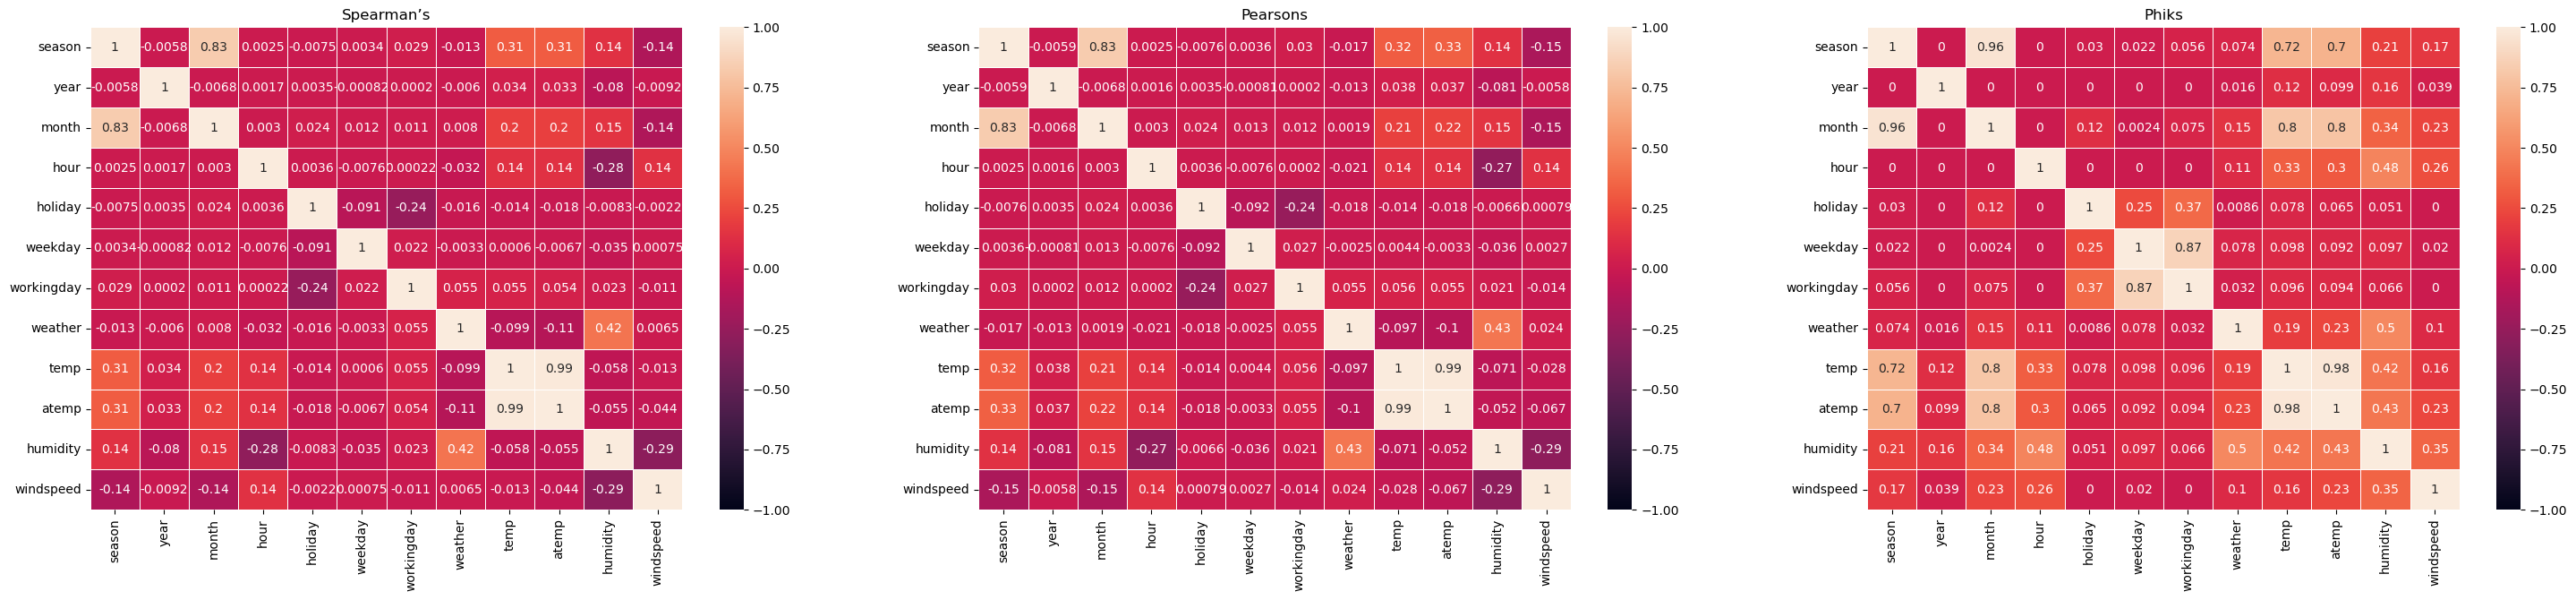

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15, 7))
plt.subplots_adjust(right=2)

columns = X_train.columns.values
SpearCorr = df_train[columns].corr(method='spearman')

ax1.set_title("Spearman’s")
sns.heatmap( SpearCorr, annot=True, vmin=-1 , vmax=1 , linewidths=0.5 , ax=ax1)

PearsonCorr = df_train[columns].corr()
ax2.set_title("Pearsons")
sns.heatmap(PearsonCorr, annot=True, vmin=-1 , vmax=1 , linewidths=0.5 , ax=ax2)

PhikCorr = df_train[columns].phik_matrix()
ax3.set_title("Phiks")
sns.heatmap(PhikCorr, annot=True, vmin=-1 , vmax=1 , linewidths=0.5 , ax=ax3)

- The corleation heatmaps further show us that atemp and temp has a very high corelation so we will drop on of these, because they increase the standard error and variance which  make the solver’s job harder.
- Season and month have a high corelation aswell so once again we will remove one of these for the same reason explained above.
- We also see that registered, count and casual have a high corelation between eachother however there is no need to drop any of these as they are all targets.
- Working day has a high corelation with weekdays. Drop workingday as you can tell if its a working day based on weekend and holiday values.

## Dropping temp, season and workinday

In [16]:
# Drop from data frame 
df_train = df_train.drop(['temp','season','workingday','month'], axis=1 )
print("Columns in train dataframe", df_train.columns.values)


df_test = df_test.drop(['temp','season','workingday','month'], axis=1 )
print("Columns in test dataframe", df_test.columns.values)

# Drop from predictors
X_train = X_train.drop(['temp','season','workingday','month'],axis=1)
print("Features Train:", X_train.columns.values)


X_test = X_test.drop(['temp','season','workingday','month'],axis=1)
print("Features Test:", X_train.columns.values)


Columns in train dataframe ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed' 'casual' 'registered' 'count']
Columns in test dataframe ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed' 'casual' 'registered' 'count']
Features Train: ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed']
Features Test: ['year' 'hour' 'holiday' 'weekday' 'weather' 'atemp' 'humidity'
 'windspeed']


 - Decided to drop temp as atemp is the actual temperature felt on the day which might affect poeples choises for renting bikes more than the forecasted temp.
 - Decided to drop season over month as season is less specific than month

In [17]:
### TO-DO Add description of how model will be formed

##End of Answer 2##

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

##Start of Answer 3##

## Configure template model, so we an later configure it for sepcific fits

In [18]:
model = linear_model.LinearRegression()

## Scale the Features

we scale the features to minimize the effect of outliers but also to make the machine learnings job easier.

### Standard Scaler

In [19]:
standard_scaler = StandardScaler()

X_train_standard = standard_scaler.fit_transform(X_train) 
X_train_standard = pd.DataFrame(X_train_standard, index=X_train.index, columns=X_train.columns) # Convert it back to df from array

X_test_standard = standard_scaler.transform(X_test)
X_test_standard = pd.DataFrame(X_test_standard, index=X_test.index, columns=X_test.columns) # Convert it back to df  from array

print(X_train_standard.head(3))

           year      hour   holiday   weekday   weather     atemp  humidity  \
14834  0.999712 -0.659663 -0.166116  1.483210 -0.664640  0.228375 -0.553218   
8912   0.999712 -0.949172 -0.166116  0.487432  2.474039 -0.738566  1.578069   
7644  -1.000288 -1.238681 -0.166116 -1.504125  0.904699 -0.387057  0.174538   

       windspeed  
14834   0.761401  
8912   -0.818319  
7644    0.761401  


### MinMax Scaler

In [20]:
minmax_scaler = MinMaxScaler()

X_train_minmax = minmax_scaler.fit_transform(X_train) 
X_train_minmax = pd.DataFrame(X_train_minmax, index=X_train.index, columns=X_train.columns) # Convert it back

print(X_train_minmax.head(3))

       year      hour  holiday   weekday  weather   atemp  humidity  windspeed
14834   1.0  0.304348      0.0  1.000000      0.0  0.5152      0.52   0.339316
8912    1.0  0.217391      0.0  0.666667      1.0  0.3485      0.93   0.107203
7644    0.0  0.130435      0.0  0.000000      0.5  0.4091      0.66   0.339316


## Create findNextBestPredictor func and use it to compare two different scaling approaches

In [21]:
def findNextBestPredictor(X,y,foundPredictors):
    nP = X.shape[1] # number of columns in X
    allPredictors = list(X) # See https://stackoverflow.com/a/19483025
    predictorsToSearch = set(allPredictors) - set(foundPredictors)
    maxScore = 0 # can usually do better than this!
    for predictor in predictorsToSearch: # loop over all remaining columns (predictors) in X
        trialPredictors = set(foundPredictors)
        trialPredictors.add(predictor) # Add this predictor to the existing predictors
        XcolSubset = X.loc[:,list(trialPredictors)] # all rows and just the trial predictors
        model.fit(XcolSubset, y) # fit the model to y
        score = model.score(XcolSubset, y)
        if score > maxScore: # identify the largest score and its associated predictor
            maxScore = score
            bestPredictorFound = predictor
    
    return (maxScore, bestPredictorFound)

print("Standard Scaler:",findNextBestPredictor(X_train_standard,y_train['count'],list()))
print("MinMax Scaler:", findNextBestPredictor(X_train_minmax,y_train['count'],list()))
print("No Scalling:", findNextBestPredictor(X_train, y_train['count'],list()))

Standard Scaler: (0.3206226511361153, 'hour')
MinMax Scaler: (0.3206226511361153, 'hour')
No Scalling: (0.3206226511361153, 'hour')


- Both Standard Scaler and MinMax Scaler show the same percentages so we can choose either of them, Standars Scaler was chosen for this project

## Compare the next best predictors for our 3 targets

In [22]:
def nextBestPredictor(X, y):
    nP = X_train.shape[1]
    scores = [0]
    foundPredictors = list()

    for i in range(nP): # loop over all columns (predictors) in X
        (score, bestPredictorFound) = findNextBestPredictor(X, y, foundPredictors)
        foundPredictors.append(bestPredictorFound)
        scores.append(score)
        print(foundPredictors, score)
        
    plt.title("Score versus predictors")
    plt.xlabel('Number of predictors') 
    plt.ylabel('R squared')
    plt.plot(scores)

['hour'] 0.3206226511361153
['hour', 'atemp'] 0.4189786035772317
['hour', 'atemp', 'humidity'] 0.45316263120142386
['hour', 'atemp', 'humidity', 'year'] 0.47380138412081996
['hour', 'atemp', 'humidity', 'year', 'weekday'] 0.4749159751978983
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed'] 0.4754566697506106
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday'] 0.4754898003155287
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday', 'weather'] 0.4755154712686763


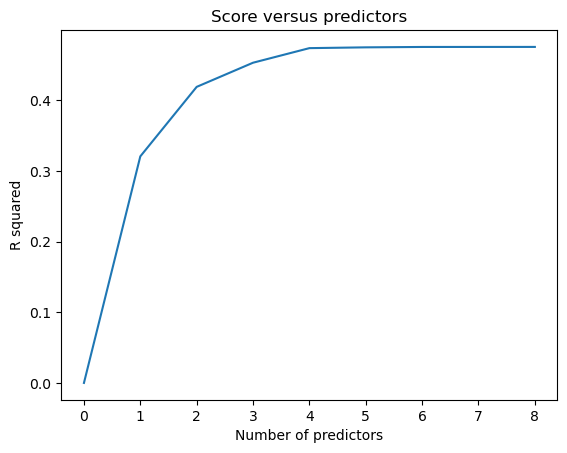

In [23]:
nextBestPredictor(X_train_standard, y_train['count'])

['hour'] 0.3206226511361153
['hour', 'atemp'] 0.4189786035772317
['hour', 'atemp', 'humidity'] 0.45316263120142386
['hour', 'atemp', 'humidity', 'year'] 0.47380138412081996
['hour', 'atemp', 'humidity', 'year', 'weekday'] 0.4749159751978984
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed'] 0.4754566697506106
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday'] 0.4754898003155287
['hour', 'atemp', 'humidity', 'year', 'weekday', 'windspeed', 'holiday', 'weather'] 0.4755154712686763


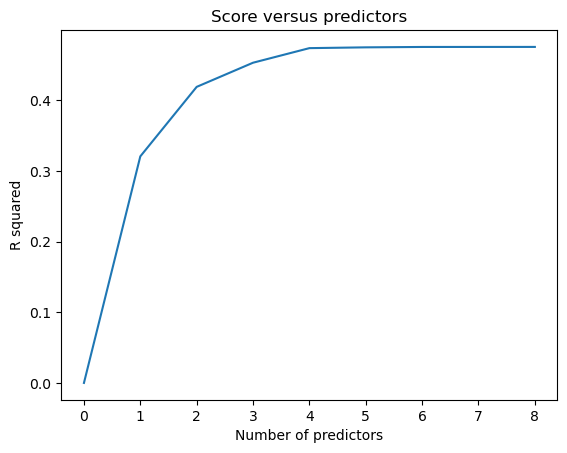

In [24]:
nextBestPredictor(X_train_minmax, y_train['count'])

- A closer look with the help of nextbespredictor shows us that the two different scaling methods show a very small difference this can be seen when adding weekdday to the predictors list standard_scaler : 0.0.4749159751978983 and minmax : 0.4749159751978984 , a miniscule difference can be seen. Other scalers such as Robust and MaxAbs were also checked and gave similar outputs so we will continue on with standard scaler as we have already used it for scaling the test set aswell.



['hour'] 0.1436530402879156
['hour', 'atemp'] 0.22783963904118343
['hour', 'atemp', 'year'] 0.28728350752049936
['hour', 'atemp', 'year', 'humidity'] 0.31063038702631507
['hour', 'atemp', 'year', 'humidity', 'holiday'] 0.3118600473754496
['hour', 'atemp', 'year', 'humidity', 'holiday', 'windspeed'] 0.3123919892405199
['hour', 'atemp', 'year', 'humidity', 'holiday', 'windspeed', 'weekday'] 0.3128505598835515
['hour', 'atemp', 'year', 'humidity', 'holiday', 'windspeed', 'weekday', 'weather'] 0.31313927217858295


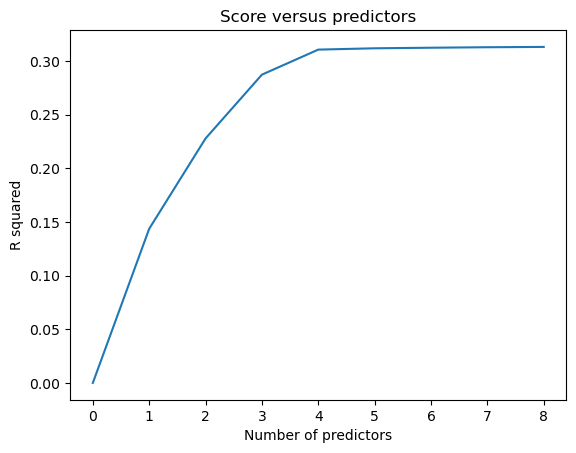

In [25]:
nextBestPredictor(X_train_standard, y_train['registered'])

['atemp'] 0.20920439449359363
['atemp', 'humidity'] 0.3121829305975563
['atemp', 'humidity', 'hour'] 0.33667736628466816
['atemp', 'humidity', 'hour', 'year'] 0.3477134659354487
['atemp', 'humidity', 'hour', 'year', 'holiday'] 0.3503155671111633
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday'] 0.3516586722652473
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday', 'windspeed'] 0.3520004690208802
['atemp', 'humidity', 'hour', 'year', 'holiday', 'weekday', 'windspeed', 'weather'] 0.3520051870399409


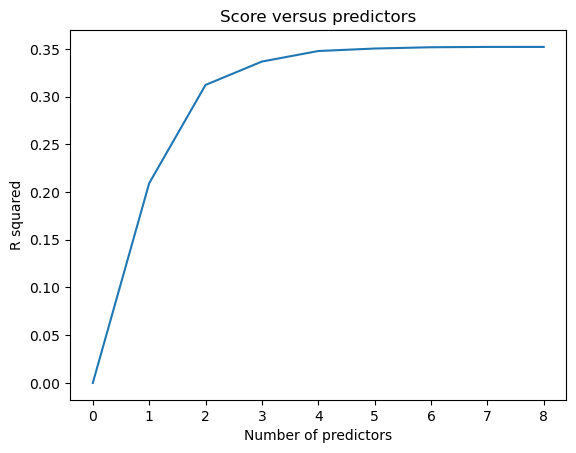

In [26]:
nextBestPredictor(X_train_standard, y_train['casual'])

- Count is clearly the easiest to predict as its scores are clearly higher than others both per feature and overall. Count is our preffered target and will be used to check and compare accuracy between models.Which of the two machine learning procedures provides the highest prediction accuracy on the test set? 

- The first 4 features (hour, atemp, humidity and year) are the best predictors, all the features after dont add much value.

##  Creating new data frame to only contain the best predictors

In [27]:
best_predictors = ['hour', 'atemp', 'humidity', 'year']
X_train_linear = X_train_standard[best_predictors]
X_test_linear = X_test_standard[best_predictors]

## Model Fit for Count Target (Preffered Target)

<AxesSubplot:title={'center':'Model coefficients'}>

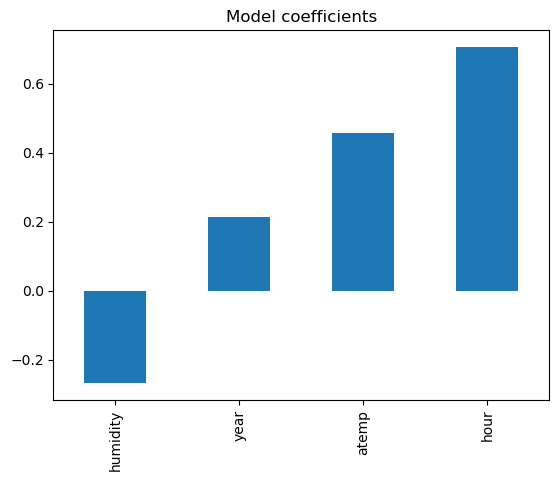

In [28]:
count_model=model.fit(X_train_linear, y_train['count'])
count_coef = pd.Series(count_model.coef_,best_predictors).sort_values()

count_coef

count_coef.plot(kind='bar', title="Model coefficients")

- Both humidity and atemp model coefficients  have large avlues with oppsoite signs which is a problem. The high values and opposite signs means theat the two are corelaated and that we missed itduring the EDA. This can be adresssed by removing one of the features or regularisation which penalises the two coefficients.


### Attempting Regularisation for Count Using Ridge Regression 

In [29]:
ridgeReg = Ridge(alpha=100)

ridgeReg.fit(X_train_linear, y_train['count'])
ridgeReg.score(X_train_linear, y_train['count'])

0.4737737316229147

In [30]:
ridge_coef = pd.Series(ridgeReg.coef_,best_predictors).sort_values()
ridge_coef

humidity   -0.266532
year        0.212541
atemp       0.454913
hour        0.699787
dtype: float64

- Ridge regression changes very little so in order for a better comparison with the other targets we will not use these noew coefficients

## Calculating  10 fold cross validations scores for Count

In [31]:
cv_score_count = model_selection.cross_val_score(count_model, X_train_linear,y_train['count'], cv=KFold(n_splits=10, shuffle=True,
                                            random_state=1), n_jobs=-1)
print(cv_score_count)

[0.47648008 0.49592362 0.45645234 0.4610703  0.47755843 0.47797069
 0.50224018 0.44411908 0.47326597 0.4635349 ]


### Checking Residuals for Count model

In [32]:
y_predict_count = count_model.predict(X_test_linear)

y_predict_count_train = count_model.predict(X_train_linear)
y_predict_count_train

array([4.53925259, 3.32244519, 3.22528121, ..., 5.01785224, 3.14956795,
       4.89301914])

[Text(0.5, 0, 'Errors'), Text(0, 0.5, 'Count')]

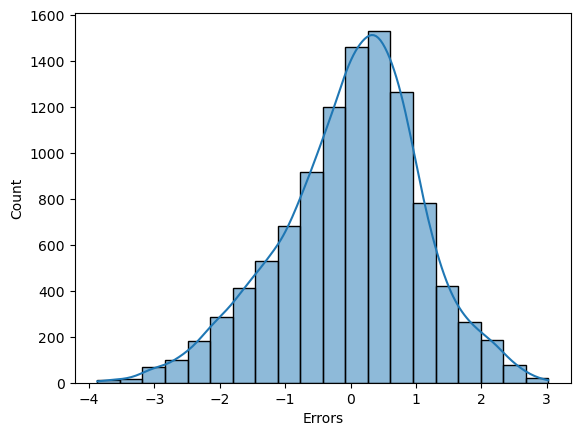

In [33]:
residuals = y_train['count'] - y_predict_count_train


fig = sns.histplot((residuals), bins = 20, kde=True)
fig.set(xlabel="Errors" , ylabel="Count")

- Residuals seem to be normally distributed so we can assume linear regression model is valid

## Checking Count Model Score

In [34]:
count_score=count_model.score(X_test_linear, y_test['count'])

## Model Fit for Casual  Target 

humidity   -13.421188
year         5.274817
hour         8.343448
atemp       20.840086
dtype: float64


<AxesSubplot:title={'center':'Model coefficients'}>

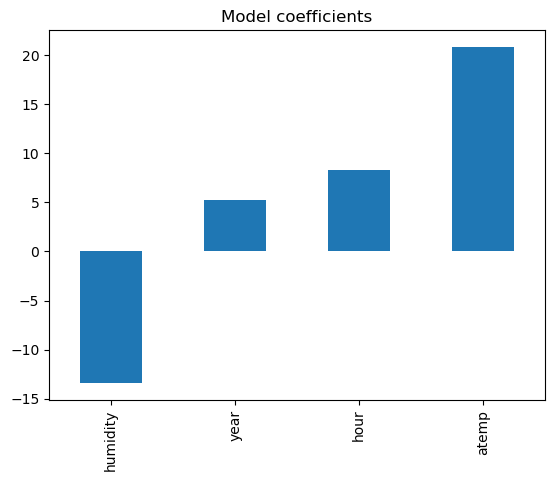

In [35]:
casual_model =model.fit(X_train_linear, y_train['casual'])
casual_coef = pd.Series(casual_model.coef_,best_predictors).sort_values()

print (casual_coef)

casual_coef.plot(kind='bar', title="Model coefficients")

- Note: the values here are higher as they were not transformed with log. We can also see  humidity and atemp have a high corelation we wont be doing any regularisation as this isnt the preffered target.

## Calculating  10 fold cross validations scores for Casual

In [36]:
cv_score_casual = model_selection.cross_val_score(casual_model, X_train_linear,y_train['casual'], cv=KFold(n_splits=10, shuffle=True,
                                            random_state=1), n_jobs=-1)
print(cv_score_casual)

[0.34601253 0.35429287 0.37198719 0.36437931 0.34766239 0.36176405
 0.33788044 0.32205524 0.310619   0.35364144]


## Checking casual Model Score

In [37]:
casual_score=casual_model.score(X_test_linear, y_test['casual'])

## Model Fit for Registered Target 

<AxesSubplot:title={'center':'Model coefficients'}>

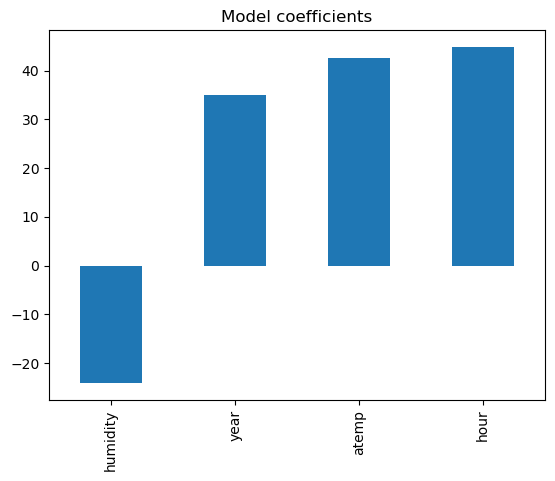

In [38]:
registered_model = model.fit(X_train_linear, y_train['registered'])
registered_coef = pd.Series(registered_model.coef_,best_predictors).sort_values()

registered_coef

registered_coef.plot(kind='bar', title="Model coefficients")

- Note: the values here are higher as they were not transformed with log. We can also see  humidity and hour have a high corelation we wont be doing any regularisation as this isnt the preffered target.

## Calculating  10 fold cross validations scores for Registered

In [39]:
cv_score_registered = model_selection.cross_val_score(model, X_train_linear,y_train['registered'], cv=KFold(n_splits=10, shuffle=True,
                                            random_state=1), n_jobs=-1)
print(cv_score_registered)

[0.31895742 0.31866144 0.29269142 0.28176965 0.31777022 0.32109727
 0.33602863 0.26550273 0.3215799  0.32067416]


## Checking Registered Model Score

In [40]:
registered_score=registered_model.score(X_test_linear, y_test['registered'])

##End of Answer 3##

# Task 4: Which of the 3 target columns is easiest to predict accurately?

##Start of Answer 4##

## Comparing cross validation values for different targets

In [41]:
print(f"Accuracy CV for Registered mean score: {cv_score_registered.mean():.2%}  std: {cv_score_registered.std():.2%}")
print(f"Accuracy CV for Casual mean score: {cv_score_casual.mean():.2%}  std: {cv_score_casual.std():.2%}")
print(f"Accuracy CV for Count mean score: {cv_score_count.mean():.2%}  std: {cv_score_count.std():.2%}")

print(f"Score for Count: {count_score}")
print(f"Score for Casual: {casual_score}")
print(f"Score for Registered: {registered_score}")

Accuracy CV for Registered mean score: 30.95%  std: 2.08%
Accuracy CV for Casual mean score: 34.70%  std: 1.81%
Accuracy CV for Count mean score: 47.29%  std: 1.67%
Score for Count: 0.45478793050522504
Score for Casual: 0.3473222141006935
Score for Registered: 0.2938093387871814


- The Cross Validation accuracy and model score is the best for count meaning it would be the easiest to predict accurately 

##End of Answer 4##

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label

##Start of Answer 5##

## Conversion of count(numerical) to count_quartile(categorical) and addition of new column to store count_quartile

In [42]:
## Add Labels to training set
train_quartiles = pd.qcut(y_train['count'], 4, labels=False)
y_train = y_train.assign(count_quartile=train_quartiles.values+1)  # +1 as 1st quartile is marked as 0 by default


## Add Labels to test set
test_quartiles = pd.qcut(y_test['count'], 4, labels=False)
y_test = y_test.assign(count_quartile=test_quartiles.values+1)  # +1 as 1st quartile is marked as 0 by default


y_train.head(10)

,casual,registered,count,count_quartile
14834,10,63,4.290459,2
8912,0,16,2.772589,1
7644,6,31,3.610918,1
3971,58,111,5.129899,3
16570,0,4,1.386294,1
6142,135,229,5.897154,4
4937,40,129,5.129899,3
13059,42,604,6.470800,4
7873,8,346,5.869297,4
13419,55,624,6.520621,4


##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles

##Start of Answer 6

## Function to display accuracy score , confusion matrix and classification report for a classification model.

In [43]:
def showDiagnostics(y_test, y_pred):
  # Model Accuracy, how often is the classifier correct?
  print("Accuracy:",accuracy_score(y_test, y_pred))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))
  print("Classification Report:")
  print(classification_report(y_test, y_pred, digits=3))

## Naive Bays

### Setting model to Naive Bayes

In [44]:
model = GaussianNB()

### Finding next best predictors for count quartile using knn model

['hour'] 0.48863527380838206
['hour', 'atemp'] 0.5523161024263931
['hour', 'atemp', 'year'] 0.566989546370001
['hour', 'atemp', 'year', 'weather'] 0.5740865061858637
['hour', 'atemp', 'year', 'weather', 'weekday'] 0.5753332693967584
['hour', 'atemp', 'year', 'weather', 'weekday', 'windspeed'] 0.5738946964611106
['hour', 'atemp', 'year', 'weather', 'weekday', 'windspeed', 'holiday'] 0.5733192672868515
['hour', 'atemp', 'year', 'weather', 'weekday', 'windspeed', 'holiday', 'humidity'] 0.5608516351779035


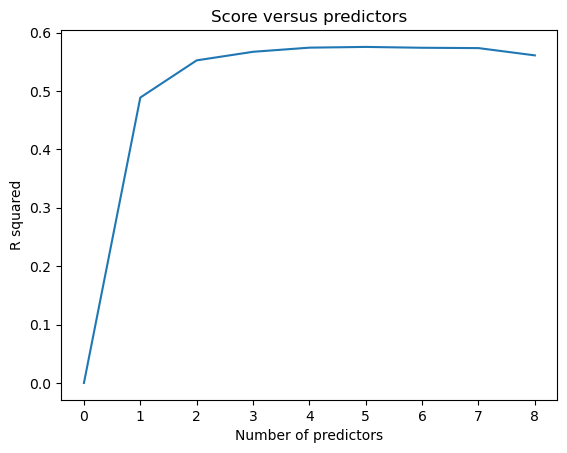

In [45]:
nextBestPredictor(X_train_standard, y_train['count_quartile'])

### Creating dataframe to only contain best predictors

In [46]:
nb_best_predictors = ['hour', 'atemp', 'year']
X_train_nb = X_train_standard[nb_best_predictors]
X_test_nb = X_test_standard[nb_best_predictors]

X_train_nb.head(3)

,hour,atemp,year
14834,-0.659663,0.228375,0.999712
8912,-0.949172,-0.738566,0.999712
7644,-1.238681,-0.387057,-1.000288


### Fitting model using best predictors

In [47]:
model_nb = GaussianNB().fit(X_train_nb, y_train['count_quartile'])  

### Predicting values

In [48]:
y_pred_nb = model_nb.predict(X_test_nb)
y_pred_nb

array([3, 2, 1, ..., 4, 3, 4])

### Checking different accuracy scores

In [49]:
showDiagnostics(y_test['count_quartile'], y_pred_nb)

Accuracy: 0.5599827387802071
Confusion Matrix:
[[1566  135   31    8]
 [ 645  663  317  127]
 [ 252  290  526  660]
 [ 222   37  335 1138]]
Classification Report:
              precision    recall  f1-score   support

           1      0.583     0.900     0.708      1740
           2      0.589     0.378     0.461      1752
           3      0.435     0.304     0.358      1728
           4      0.589     0.657     0.621      1732

    accuracy                          0.560      6952
   macro avg      0.549     0.560     0.537      6952
weighted avg      0.549     0.560     0.537      6952



In [50]:
nb_score = model_nb.score(X_test_nb,y_test['count_quartile'])
nb_score

0.5599827387802071

#### Classification report parts explained:

- Accuracy - how often is it correct
- Recall - out of all the cases that exist how many did we predict correctly
- Precision - out of all the cases that we predicted how many were correct
- f1-score - harmonic mean of precision and recall
- macro avg - Average the precision and recall of the system on different classes.

### The part that intrests us the most out of the diagnostics is the classification report

- Naive Bays is correct 56% of the time (acuracy)
- The precision seems to be even throughout all quartile bar the 3rd quartile where its lower by ~15% when compared to other
- The recall percentage is significantly higher for the 1st quartile as it nears 90% the 4th quartile also has a higher percentage at 65% compared the 2nd and 3rd quartile at sub 40%
- The F1 score sums up precision and recall by finding their harmonic mean, basically combines precision and recall using a formula. The average f1 score here is 0.54. and is a good inidcation of how good the model is.

## KNN

### Setting model to KNN

In [51]:
model=KNeighborsClassifier(n_neighbors=5)

### Finding next best predictors for count quartile using knn model

['hour'] 0.5405198043540808
['hour', 'atemp'] 0.654358875995013
['hour', 'atemp', 'weekday'] 0.7904478757072984
['hour', 'atemp', 'weekday', 'year'] 0.8255490553371055
['hour', 'atemp', 'weekday', 'year', 'holiday'] 0.8312074422173205
['hour', 'atemp', 'weekday', 'year', 'holiday', 'weather'] 0.8248777213004699
['hour', 'atemp', 'weekday', 'year', 'holiday', 'weather', 'humidity'] 0.793516831303347
['hour', 'atemp', 'weekday', 'year', 'holiday', 'weather', 'humidity', 'windspeed'] 0.7632108947923659


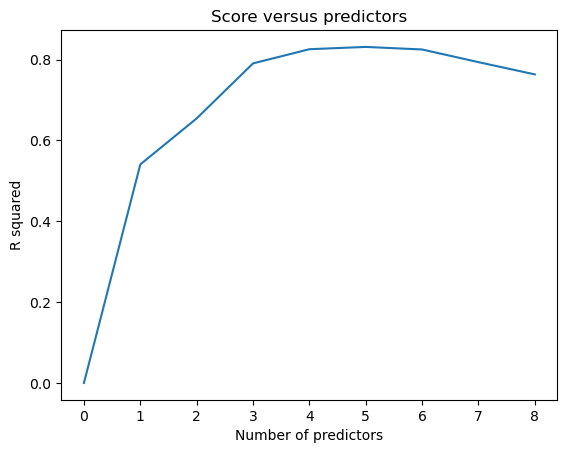

In [52]:
nextBestPredictor(X_train_standard, y_train['count_quartile'])

### Creating dataframe to only contain best predictors

In [53]:
knn_best_predictors = ['hour', 'atemp', 'weekday', 'year']
X_train_knn = X_train_standard[knn_best_predictors]
X_test_knn = X_test_standard[knn_best_predictors]

X_train_knn.head(3)

,hour,atemp,weekday,year
14834,-0.659663,0.228375,1.483210,0.999712
8912,-0.949172,-0.738566,0.487432,0.999712
7644,-1.238681,-0.387057,-1.504125,-1.000288


### Fitting model using best predictors

In [54]:
model_knn = model.fit(X_train_knn, y_train['count_quartile'])

### Predicting values

In [55]:
y_pred_knn = model_knn.predict(X_test_knn)
y_pred_knn

array([2, 2, 1, ..., 3, 3, 4])

### Checking different accuracy scores

In [56]:
showDiagnostics(y_test['count_quartile'], y_pred_knn)

Accuracy: 0.7294303797468354
Confusion Matrix:
[[1527  183   22    8]
 [ 238 1142  316   56]
 [  27  382 1030  289]
 [   5   56  299 1372]]
Classification Report:
              precision    recall  f1-score   support

           1      0.850     0.878     0.863      1740
           2      0.648     0.652     0.650      1752
           3      0.618     0.596     0.607      1728
           4      0.795     0.792     0.794      1732

    accuracy                          0.729      6952
   macro avg      0.728     0.729     0.728      6952
weighted avg      0.728     0.729     0.728      6952



In [57]:
knn_score = model_knn.score(X_test_knn,y_test['count_quartile'])
knn_score

0.7294303797468354

### Again the part that intrests us the most out of the diagnostics is the classification report

- Naive Bays is correct 72.9% of the time (accuracy)
- The precision seems to be higher in the 1st and 4th quartile ~85-80% and the 2nd and 3rd quartile is lower by ~20% respectively.
- The callback percentage is significantly higher for the 1st quartile as its at 87.8% the 4th quartile also has a higher percentage at 79% compared the 2nd and 3rd quartile at ~60-65%.
- The average f1 score for KNN is .7285

## Contrasting KNN and Naive Bays

 - KNN has a higher accuracy percentage by 17% when compared to NB 56%
 - KNN precision average comes out to 0.727 while NB precision average comes to 0.55. Again Knn beats NB on precision
 - KNN recall avearge comes out to 0.72 while NB callback average is 0.56
 - Knn has a higher f1 score than NB by 0.18
 - Overall KNN was the better fit classification for this dataset and was more accurate as it can be clearly seen with the difference in the accuracy, precision , recall and f1-score.
 
 
Naive Bayes uses generative learning to learn how the data was generated while KNN uses discriminative learning to derive the function that assigns class labels this means that given a set of features and target with labels  NB tries to find what feature data fits a specific label while KNN tries to find what label fits the features data. This could be why KNN is better at predicting the target.Perhaps if we increased the number of labels we would see a smaller difference in accuracy and precision between the two models.

KNN was only using 5 nearest neighbours so if we increased this we might have seen even better results.

Although when comparing the best predictors it was obvious that KNN was better as it had a value of 0.79 with the top3 predictors while NB only had 0.56.

The top predictors differed for each:
  - KNN top predictors were hour, atemp, weekday and year and gave a value of 0.8255490553371055
  - NB top predictors were hour, atemp, year and 'weather and gave a value of 0.5740865061858637model_knn
 

##End of Answer 6##

# Task 7: Which of the two machine learning procedures provides the highest prediction accuracy on the test set?

##Start of Answer 7

Both of the classification models have a higher accuracy than the regression model. However this is likely due to the fact that we are comparing linear regression which is suited for prediction of numerical values with classification which is suited for prediticion of categorical values.

Regression has a harder job as it has a continous amount of values that it can predict which makes it hared while classification is only limited to the number of values a label has (4 in our case). I would expect the accuracy of the classification models to decrease as we increased the number of categorical values eg use percentiles instead of quartiles.

In [58]:
data = [["KNN",knn_score],["NB", nb_score],["Linear",count_score]]
df_score = pd.DataFrame(data,columns=["procedure","score"])

df_score

,procedure,score
0,KNN,0.729430
1,NB,0.559983
2,Linear,0.454788


<AxesSubplot:xlabel='procedure', ylabel='score'>

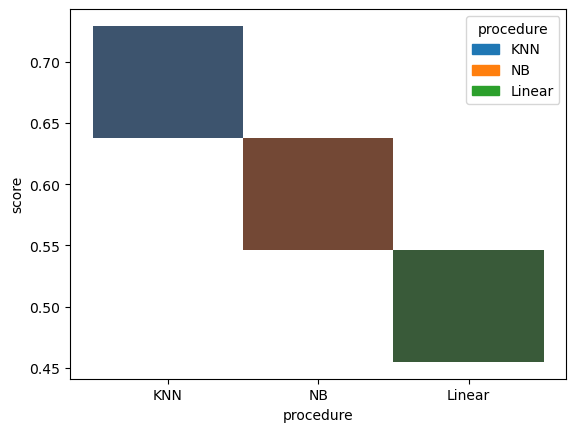

In [59]:
sns.histplot(df_score ,x="procedure" , y="score" , hue="procedure")

##End of Answer 7##